## AdaBoost算法

### AdaBoost算法描述

**AdaBoost**是AdaptiveBoost的缩写，表明该算法是具有适应性的提升算法。

算法的步骤如下：

1）给每个训练样本（$x_{1},x_{2},….,x_{N}$）分配权重，初始权重$w_{1}$均为1/N。

2）针对带有权值的样本进行训练，得到模型$G_m$（初始模型为G1）。

3）计算模型$G_m$的误分率$e_m=\sum_{i=1}^Nw_iI(y_i\not= G_m(x_i))$

4）计算模型$G_m$的系数$\alpha_m=0.5\log[(1-e_m)/e_m]$

5）根据误分率e和当前权重向量$w_m$更新权重向量$w_{m+1}$。

6）计算组合模型$f(x)=\sum_{m=1}^M\alpha_mG_m(x_i)$的误分率。

7）当组合模型的误分率或迭代次数低于一定阈值，停止迭代；否则，回到步骤2）

### AdaBoost代码

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
class Adaboost:
    """
    构建AdaBoost
    """
    
    def __init__(self, n_estimators=50, learning_rate = 1.0):
        """初始化超参数"""
        
        self.clf_num = n_estimators
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        """初始化参数"""
        
        self.error_array = []
        self.iter = []
#         self.train_error = 1111111
        self.Y = labels
        self.X = datasets
        self.M, self.N = datasets.shape
        
        self.clf_sets = []  # 记录分类器参数
        self.weights = [1.0/self.M] * self.M #初始化权重
        
        self.alpha = [] #每一个分类器的系数
        
    def _G(self, features, labels, weights):
        """基本分类器"""
        
        m = len(features)
        error = 100000.0
        best_v = 0.0 #　最优切分点
        features_min = min(features)
        features_max = max(features)
        
        # 遍历次数
        n_step = (features_max - features_min+self.learning_rate)//self.learning_rate
        
        direct, compare_array = None, None
        
        for i in range(1, int(n_step)):
            v = features_min + self.learning_rate*i
            
            if v not in features:
                
                # positive
                # 寻找最优的切分点
                compare_array_positive = np.array([
                    1 if features[k] > v else -1 for k in range(m)
                ])
                
                # 计算误分类率
                weights_error_positive = sum([
                    weights[k] for k in range(m) if compare_array_positive[k] != labels[k]
                ])
                
                # negative
                compare_array_negative = np.array([
                    -1 if features[k] > v else 1 for k in range(m)
                ])
                weights_error_negative = sum([
                    weights[k] for k in range(m) if compare_array_negative[k] != labels[k]
                ])
                
                if weights_error_positive < weights_error_negative:
                    weight_error = weights_error_positive
                    _compare_array = compare_array_positive
                    direct = "positive"
                else:
                    weight_error = weights_error_negative
                    _compare_array = compare_array_negative
                    direct = "negative"
                    
                #记录一次遍历之后最小误差的数据
                
                if weight_error < error:
                    
                    error = weight_error
                    compare_array = _compare_array
                    best_v = v #最优切分点
                    
        return best_v, direct, error, compare_array
    
    def _alpha(self, error):
        """计算分类器系数"""
        
        return 0.5 * np.log((1 - error) / error)
    
    def _Z(self, weights, a, clf):
        """计算规范化因子"""
        
        return sum([
            weights[i] * np.exp(-1 * a * self.Y[i] * clf[i]) for i in range(self.M)
        ])
    
    def _w(self, a, clf, Z):
        """计算新一步的权值"""
        
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(
            -1 * a * self.Y[i] *clf[i]) / Z
            
    def G(self, x, v , direct):
        """决策树桩"""
        
        if direct == "positive":
            return 1 if x>v else -1
        else:
            return -1 if x>v else 1
        
    def fit(self, X, y):
        """训练数据"""
        
        self.init_args(X, y)
        axis = 0 #记录最优切分变量
        best_clf_error, best_v, clf_result = 100000, None, None
        
        #开始迭代
        for epoch in range(self.clf_num):
            for j in range(self.N):  # 选取不同的特征维度进行考量
                features = self.X[:, j] # 遍历第j个切分变量的所有的所有切分点
                    
                v, direct, error, compare_array = self._G(
                    features, self.Y, self.weights)

                if error < best_clf_error:
                    best_clf_error = error
                    self.error_array.append(best_clf_error)
                    self.iter.append(epoch+1)
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array # 记录分类器输出的结果
                    axis = j # 记录最优切分变量
                if best_clf_error == 0:
                    break

            # 计算分类器系数
            a = self._alpha(best_clf_error)
            self.alpha.append(a)
                
            # 记录分类器参数
            self.clf_sets.append((axis, best_v, final_direct))

            # 记录规范化因子
            Z = self._Z(self.weights, a, clf_result) 

            # 权重更新
            self._w(a, clf_result, Z)
            
            #计算训练误差
#             self.train_error = self.score(X, y)

    def predict(self, feature):
        """预测"""
        
        result = 0.0
        print("ssss", self.alpha)
        for i in range(len(self.clf_sets)):  # 遍历所有的分类器
            axis, clf_v, direct = self.clf_sets[i]
            f_input = feature[axis]  # 找到所对应的最优切分变量
            result += self.alpha[i] * self.G(f_input, clf_v, direct)
        
        return 1 if result > 0 else -1  # 符号函数sign
    
    def score(self, X_test, Y_test):
        """评估"""
        
        right_count = 0
        
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == Y_test[i]:
                right_count += 1
                
        return right_count/len(X_test)        

### 例题 8.1

In [30]:
#　1.创建数据
X = np.arange(10).reshape(10, 1)
y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])

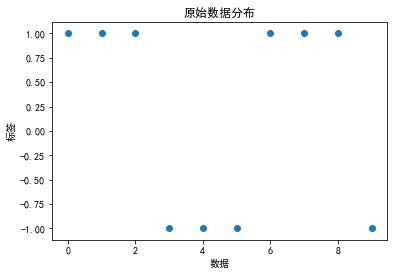

In [31]:
#　2.图形化
plt.scatter(X, y)
plt.title("原始数据分布")
plt.xlabel("数据")
plt.ylabel("标签")
plt.savefig("数据一")
plt.show()

In [32]:
#  3.预测数据
clf = Adaboost(n_estimators=16, learning_rate=0.5)
clf.fit(X, y)
clf.predict([6])

ssss [0.4236489301936017, 0.6496414920651304, 0.752038698388137, 0.752038698388137, 1.2879392139968633, 1.3776981608497036, 1.3776981608497036, 1.7737465083772515, 2.0484059358202793, 2.0484059358202793, 2.4075699486542277, 2.7354169642952266, 2.7354169642952266, 3.085154096487995, 3.4269925973897033, 3.4269925973897033]


1

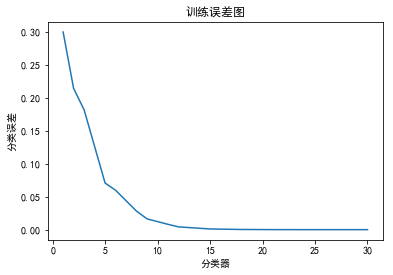

In [26]:
#  4.训练误差
plt.plot(clf.iter, clf.error_array)
plt.title("训练误差图")
plt.xlabel("分类器")
plt.ylabel("分类误差")
plt.savefig("弱分类器30")
plt.show()

### sklearn数据

In [36]:
def create_data():
    iris = load_iris()
    X = iris.data[:100,:2]
    y = iris.target[:100]
    return X, y

In [37]:
# 1.创建数据
X, y = create_data()
#改写数据标注“0”为“-1”
for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

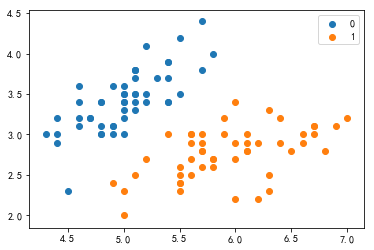

In [38]:
# 2.数据模型
X , y = create_data()
plt.scatter(X[y==0, 0], X[y==0, 1], label = "0")
plt.scatter(X[y==1, 0], X[y==1, 1], label = "1")
plt.legend()
plt.savefig("原始数据")
plt.show()

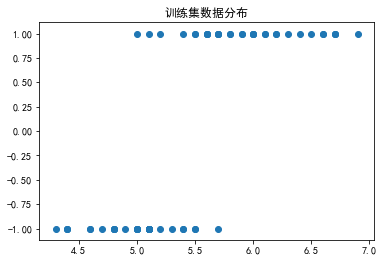

In [39]:
# 3.训练集数据分布
plt.scatter(X_train[:,0], y_train)
plt.title("训练集数据分布")
plt.savefig("训练集数据分布")
plt.show()

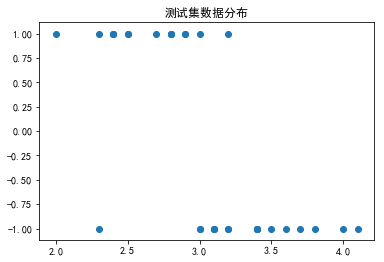

In [40]:
# 4.测试集数据分布
plt.scatter(X_test[:, 1], y_test)
plt.title("测试集数据分布")
plt.savefig("测试集数据分布")
plt.show()

In [275]:
# 4.训练和测试
clf = Adaboost(n_estimators=10, learning_rate=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7272727272727273

In [278]:
# 多次迭代
result = []
error = []
iter1 = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = Adaboost(n_estimators=50, learning_rate=0.2)
    
    clf.fit(X_train, y_train)
#     error.append(clf.train_error)
#     print(clf.error_array)
    iter1.append(i)
    
    r = clf.score(X_train, y_train)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

average score:22.970%


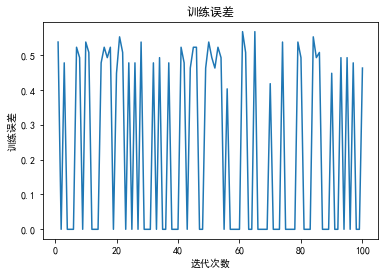

In [279]:
# 损失函数
plt.plot(iter1,result )
plt.title("训练误差")
plt.xlabel("迭代次数")
plt.ylabel("训练误差")
plt.show()